In [1]:
import torch
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from tqdm import tqdm


# NN

## Part 1

Define a simple NN model corresponding to a logistic regression model

In [2]:
def simple_nn(w1, w2, x1, x2):
    return 1./(1.+np.exp(-x1*w1 - x2*w2))


Generate data

In [3]:
#np.random.seed(42)
w_true = np.array([-1, 3])
X_data = 5 * np.random.rand(100, 2) - 2.5
y_prob = simple_nn(*w_true, X_data[:, 0], X_data[:, 1])
y_data = np.random.binomial(1, y_prob)


Data shapes

In [4]:
print(f'X_data shape {X_data.shape}')
print(f'y_data shape {y_data.shape}')


X_data shape (100, 2)
y_data shape (100,)


In [5]:
display(X_data[:10])


array([[-2.3484103 , -1.48205206],
       [-1.34566418, -0.95803572],
       [-0.90998219, -0.34143059],
       [ 1.2152231 ,  2.23906909],
       [-2.23785385, -0.39594843],
       [ 2.13837086, -0.50512876],
       [-0.6343936 , -0.77206779],
       [-1.74923282,  2.1189343 ],
       [-1.98839785, -0.83559581],
       [-0.6867768 ,  0.64397505]])

In [6]:
display(y_data[:10])


array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1])

Use the negative log-likelihood as loss function

In [7]:
@np.vectorize
def negloglik(w1, w2):
    return -1/y_data.shape[0] * (np.sum(np.log(simple_nn(w1, w2, X_data[y_data == 1, 0], X_data[y_data == 1, 1])))
                                 + np.sum(np.log(1.0 - simple_nn(w1, w2, X_data[y_data == 0, 0], X_data[y_data == 0, 1]))))


Do a bit of plotting of the error landscape

C:\Users\Vugs\AppData\Local\Temp\ipykernel_7072\3026449210.py:4: RuntimeWarning: divide by zero encountered in log
  + np.sum(np.log(1.0 - simple_nn(w1, w2, X_data[y_data == 0, 0], X_data[y_data == 0, 1]))))
c:\Users\Vugs\miniconda3\envs\p7\Lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


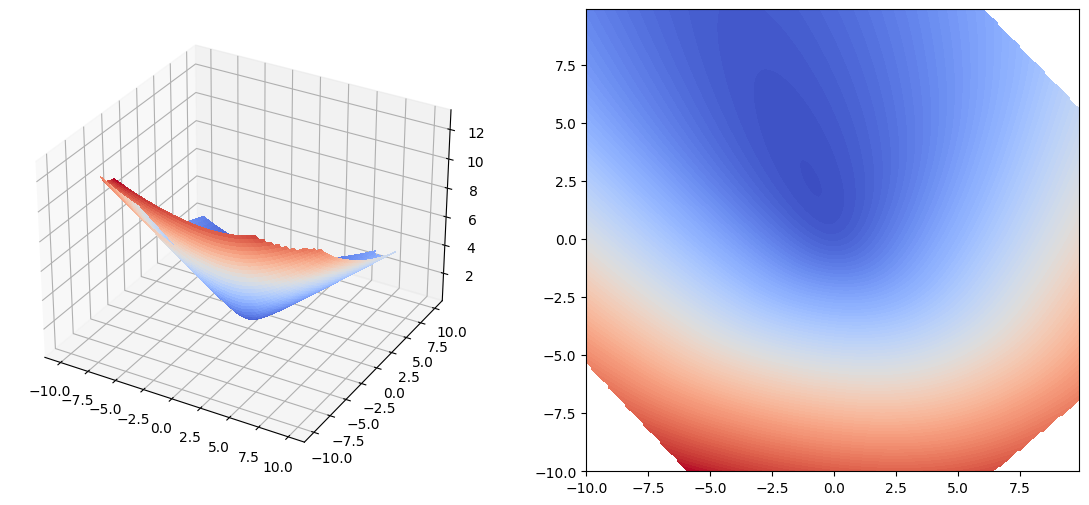

Negative log-lik for the true weights: 0.29229784405044207


In [8]:
delta = 0.1
x1 = np.arange(-10.0, 10.0, delta)
x2 = np.arange(-10.0, 10.0, delta)
# x1 = np.arange(0.5, 1.5, delta)
# x2 = np.arange(0.5, 1.5, delta)

X1, X2 = np.meshgrid(x1, x2)
Z = negloglik(X1, X2)

fig = plt.figure(figsize=(14, 6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)

ax = fig.add_subplot(1, 2, 2)
ax.contourf(X1, X2, Z, cmap=cm.coolwarm, levels=100)

plt.show()

print(f'Negative log-lik for the true weights: {negloglik(*w_true)}')


### Exercise
1. Derive the gradient of the error function
2. Implement the gradient in the function below
3. Implement the gradient descent updating procedure. Experiment by changing the number of iterations, learning rate, amnd initialization point.

In [9]:
def gradient(w, X_train=X_data, y_train = y_data):
    return -1/y_train.shape[0] * np.array([np.sum((y_train - simple_nn(*w, X_train[:, 0], X_train[:, 1])) * X_train[:, 0]),
                                             np.sum((y_train - simple_nn(*w, X_train[:, 0], X_train[:, 1])) * X_train[:, 1])])


In [10]:
def gradient_descent(lr=0.1, epochs=100, init=np.array([0,0])):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.contourf(X1, X2, Z, cmap=cm.coolwarm, levels=100)
    print(f'True weights: {w_true}')
    w = init
    pbar = tqdm(range(epochs))
    for _ in pbar:
        w = w - lr * gradient(w)
        pbar.set_description(f'w = {w}')
        ax.scatter(*w, c='g')

    plt.show()
    return w


True weights: [-1  3]


w = [0.90057568 1.15142182]: 100%|██████████| 100/100 [00:00<00:00, 406.12it/s] 


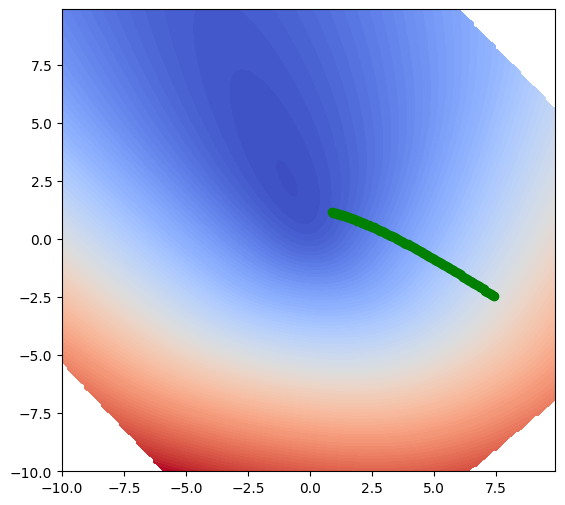

Found weights: [0.90057568 1.15142182]
NLL: 0.6404142977472139


In [11]:
w = gradient_descent(lr=0.1, init=np.array([7.5,-2.5]))
print(f'Found weights: {w}')
print(f'NLL: {negloglik(*w)}')


## Part 2

Let's check the gradient calculations using PyTorch. For an introduction, see https://pytorch.org/tutorials/beginner/basics/intro.html. 

In [12]:
sigmoid = torch.nn.Sigmoid()
relu = torch.nn.ReLU()

x1 = torch.tensor(1.0, requires_grad=True)
w1 = torch.tensor(2.0, requires_grad=True)

x2 = torch.tensor(3.0, requires_grad=True)
w2 = torch.tensor(0.5, requires_grad=True)

y1 = x1*w1
y1.register_hook(lambda grad: print("Grad y1 = {}".format(grad)))

y2 = x2*w2
y2.register_hook(lambda grad: print("Grad y2 = {}".format(grad)))

y3 = y1+y2
y3.register_hook(lambda grad: print("Grad y3 = {}".format(grad)))

y4 = sigmoid(y3)
y4.register_hook(lambda grad: print("Grad y4 = {}".format(grad)))

y5 = relu(y3)
y5.register_hook(lambda grad: print("Grad y5 = {}".format(grad)))

y6 = y4 * y5
y6.register_hook(lambda grad: print("Grad y6 = {}".format(grad)))

e = (1.0 - y6)**2

e.backward()

print("Grad x1 = {}".format(x1.grad))
print("Grad x2 = {}".format(x2.grad))
print("Grad w1 = {}".format(w1.grad))
print("Grad w2 = {}".format(w2.grad))

print("Done")


Grad y6 = 4.794814109802246
Grad y5 = 4.654267311096191
Grad y4 = 16.781848907470703
Grad y3 = 5.1317620277404785
Grad y2 = 5.1317620277404785
Grad y1 = 5.1317620277404785
Grad x1 = 10.263524055480957
Grad x2 = 2.5658810138702393
Grad w1 = 5.1317620277404785
Grad w2 = 15.395286560058594
Done


## Part 4

Implement the following neural network with PyTorch (as above), where the hidden units and the output unit have a sigmoid activation function:

<img src="sigmoid-model.png" width="1000">

Let the loss function be $loss = (Y − O)^2$ and assume that we have the training example $(X = 1, O = 1)$.
1. Using your implementation, find the partial derivatives for each of the weights in the network.
2. How do the derivatives compare? Can you see a general pattern and what are the implications for gradient descent?
3. Can you argue for why you see this particular pattern? Hint: Consider the local contributions to the gradient from the sigmoid functions (what is the maximum value of the local gradient?).

In [13]:
sigmoid = torch.nn.Sigmoid()

x1 = torch.tensor(1.0, requires_grad=True)
w1 = torch.tensor(2.0, requires_grad=True)

y1 = sigmoid(x1*w1)
y1.register_hook(lambda grad: print("Grad y1 = {}".format(grad)))

y2 = sigmoid(y1)
y2.register_hook(lambda grad: print("Grad y2 = {}".format(grad)))

y3 = sigmoid(y2)
y3.register_hook(lambda grad: print("Grad y3 = {}".format(grad)))

y4 = sigmoid(y3)
y4.register_hook(lambda grad: print("Grad y4 = {}".format(grad)))

y5 = sigmoid(y4)
y5.register_hook(lambda grad: print("Grad y5 = {}".format(grad)))

y6 = sigmoid(y5)
y6.register_hook(lambda grad: print("Grad y6 = {}".format(grad)))

e = (1.0 - y6)**2

e.backward()

print("Grad x1 = {}".format(x1.grad))
print("Grad w1 = {}".format(w1.grad))

print("Done")


Grad y6 = -0.6816657781600952
Grad y5 = -0.15314701199531555
Grad y4 = -0.034386519342660904
Grad y3 = -0.007700376212596893
Grad y2 = -0.0017032461473718286
Grad y1 = -0.00035283801844343543
Grad x1 = -7.409148383885622e-05
Grad w1 = -3.704574191942811e-05
Done


## Exercise
1. Extend your implementation from Exercise 1 with momentum
2. Experiment by changing the number of iterations, learning rate, initialization point.

In [14]:
# Add momentum to the gradient descent
def gradient_descent(lr=0.1, epochs=300, init=np.array([0,0]), momentum=0.9):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.contourf(X1, X2, Z, cmap=cm.coolwarm, levels=100)
    print(f'True weights: {w_true}')
    w = init
    v = np.zeros_like(w)
    pbar = tqdm(range(epochs))
    for _ in pbar:
        v = momentum * v + lr * gradient(w)
        w = w - v
        pbar.set_description(f'w = {w}')
        ax.scatter(*w, c='g')

    plt.show()
    return w


True weights: [-1  3]


w = [-0.89118543  2.50119573]: 100%|██████████| 300/300 [00:00<00:00, 382.86it/s]


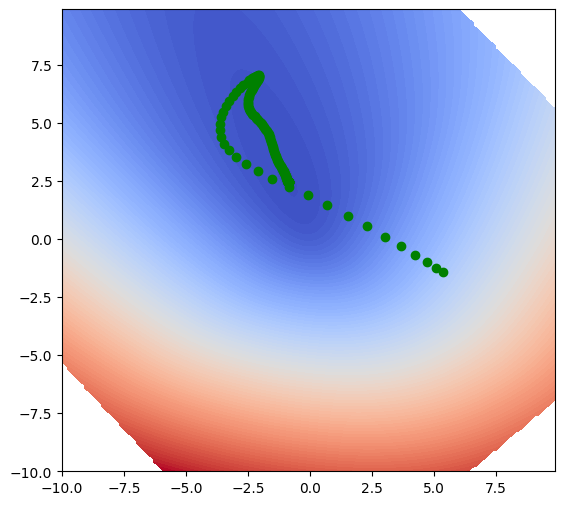

Found weights: [-0.89118543  2.50119573]
NLL: 0.2875482038295609


In [15]:
w = gradient_descent(lr=0.2, init=np.array([5.5,-1.5]))
print(f'Found weights: {w}')
print(f'NLL: {negloglik(*w)}')


## Part 5

## Exercise
1. Implement stochastic gradient descent for the model in Exercise 1.
2. Experiment by changing the number of iterations, learning rate, initialization point, mini batch size.

In [16]:
def stochastic_gradient_descent(lr=0.1, epochs=100, init=np.array([0,0]), batch_size=10, momentum=0.7):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.contourf(X1, X2, Z, cmap=cm.coolwarm, levels=100)
    print(f'True weights: {w_true}')
    w = init
    v = np.zeros_like(w)
    idx = np.arange(X_data.shape[0])
    n_batches = len(idx) // batch_size
    pbar = tqdm(range(epochs))
    for _ in pbar:
        np.random.shuffle(idx)
        for b in range(n_batches):
            batch_idx = idx[b * batch_size:(b + 1) * batch_size]

            v = momentum * v + lr * gradient(w, X_train=X_data[batch_idx], y_train=y_data[batch_idx])
            w = w - v
            pbar.set_description(f'w = {w}')
            ax.scatter(*w, c='g')
    plt.show()
    return w


True weights: [-1  3]


w = [-0.88188317  2.49832791]: 100%|██████████| 100/100 [00:00<00:00, 171.37it/s]


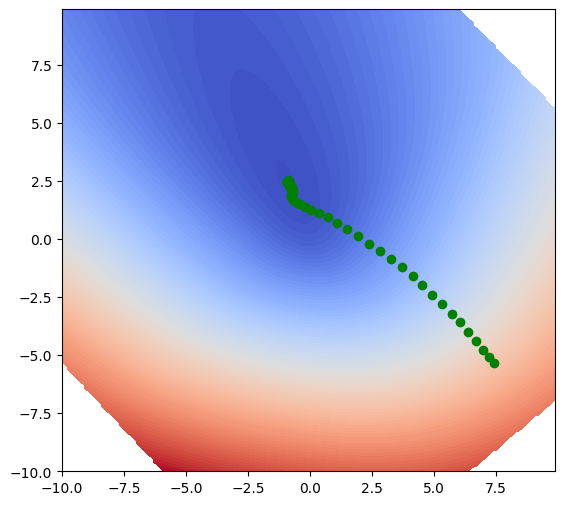

Found weights: [-0.88188317  2.49832791]
NLL: 0.28755602007525677


In [17]:
w = stochastic_gradient_descent(lr=0.2, init=np.array([7.5,-5.5]), batch_size=50)
print(f'Found weights: {w}')
print(f'NLL: {negloglik(*w)}')


## Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch, except for the calculation of the gradients, for which we rely on the functionality provided by <a urel="https://pytorch.org">PyTorch</a>. 

Since we rely on PyTorch functionality, we will also be using PyTorch's tensor data structure. This data structure operates in much the same way as numpy's ndarrays. You can find a brief introduction to PyTorch's tensors <a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html">here</a>.  



The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

First we import the modules used in this selfstudy

In [18]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np


Through torch load the MNIST data set, which we will use in this self study. The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set consisting of $60000$ images and a test set with $10000$ images; in both
data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

Using the data loader provided by torch we have an easy way of loading in data in batches (here of size 64). We can also make various other transformation of the data, such as normalization. The details for loading the data are not really that important, but if yiu are curious, you can find a quick introduction <a href="https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html">here</a>.

In [19]:
def dataload(batch_size):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])),
            batch_size=batch_size, shuffle=True)


    return train_loader, test_loader

In [20]:
batch_size = 64
train_loader_64, test_loader_64 = dataload(batch_size)

In the cell above, we are loading data in batches, which is subsequently used during optimization. We didn't discuss batch based learning during the last lecture, but please take a look at Slides 24 and 25 to get the gist of the approach. We will cover it in more detail during the next lecture.   

Each batch is a list of two elements. The first element encodes the digit and has dimensions [64,1,28,28] (the figures are greyscale with no rbg channel, hence the '1'), and the second element contains the class/label information. 

Batch dimension (digit): torch.Size([64, 1, 28, 28])
Batch dimension (target): torch.Size([64])
Target: 0 with shape torch.Size([1, 28, 28])


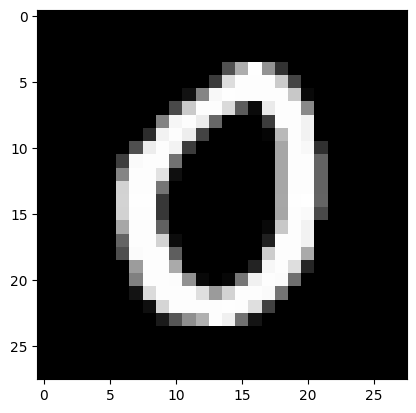

In [21]:
batch = next(iter(train_loader_64))
print(f"Batch dimension (digit): {batch[0].shape}")
print(f"Batch dimension (target): {batch[1].shape}")
digit_batch = batch[0]
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(f"Target: {batch[1][0]} with shape {img.shape}")


With PyTorch we can specify that the tensors require gradients. This will make PyTorch record all operations performed on the tensors, so that we can afterwards calculate the gradients automatically using back propagation. See also the code example from the last lecture.

For the first part of this self study we will specify a neural network, which will encode a softmax function (see, e.g., Page 180 in <a href="https://www.deeplearningbook.org/contents/mlp.html">The Deep Learning book</a>). For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. Note that to facilitate matrix multiplication we will flatten our image from $28\times 28$ to $784$. 

Out model specification

In [22]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def model(xb, weights, bias):
    return softmax(xb @ weights + bias)

Let's test our model (with our randomly initialized weights)

In [23]:
# We flatten the digit representation so that it is consistent with the weight matrix
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

xb = digit_batch.flatten(start_dim=1)
print(f"Batch shape: {xb.shape}")
preds = model(xb, weights, bias)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")


Batch shape: torch.Size([64, 784])
Prediction on first image tensor([0.0506, 0.0821, 0.1893, 0.2728, 0.0405, 0.0968, 0.1187, 0.0395, 0.0928,
        0.0170], grad_fn=<SelectBackward0>)
Corresponding classification: 3


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [24]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean()
loss_func = nll

# Make a test calculation
yb = batch[1]
print(loss_func(preds,yb))


tensor(2.5319, grad_fn=<MeanBackward0>)


In the end, we are interested in the accuracy of our model

In [25]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


In [26]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Accuracy of model on batch (with random weights): 0.140625


Now we are ready to combine it all and perform learning

In [27]:
def evaluate_model(weights, bias, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.squeeze().flatten(start_dim=1)
            outputs = model(images, weights, bias)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    return accuracy

# Exam Topic

In [28]:
def model_trainer(epochs, lr, inc_momentum, train_loader, test_loader, momentum=0.9, weights=torch.randn(784, 10) / np.sqrt(784), bias = torch.zeros(10, requires_grad=True), optimizer=None):
    train_losses = []
    weights = weights
    weights.requires_grad_()
    bias = bias
    v_weights = torch.zeros_like(weights)
    v_bias = torch.zeros_like(bias)
    optimizer = optimizer.lower() if optimizer else optimizer

    if optimizer == "sgd":
        if inc_momentum:
            optimizer = torch.optim.SGD([weights, bias], lr=lr, momentum=momentum, nesterov=True)
        else:
            optimizer = torch.optim.SGD([weights, bias], lr=lr)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam([weights, bias], lr=lr)
    elif optimizer == "rmsprop":
        optimizer = torch.optim.RMSprop([weights, bias], lr=lr)
    else:
        optimizer = None

    for epoch in range(epochs):

        for batch_idx, (xb, yb) in enumerate(train_loader):
            # We flatten the digit representation so that it is consistent with the weight matrix
            xb = xb.squeeze().flatten(start_dim=1)

            # Predictions
            pred = model(xb, weights, bias)

            # We specify the loss
            loss = loss_func(pred, yb)

            # Perform backpropagation
            loss.backward()

            with torch.no_grad():
                if optimizer is not None:
                    optimizer.step()
                    optimizer.zero_grad()
                else:
                    if inc_momentum:
                        # Update velocity and weights
                        v_weights = (momentum * v_weights) - (lr * weights.grad)
                        v_bias = (momentum * v_bias) - (lr * bias.grad)
                        weights += v_weights
                        bias += v_bias
                    else:
                        weights -= weights.grad * lr
                        bias -= bias.grad * lr

                    # After updating we set the gradients to zero so that we ar eready for the next round
                    weights.grad.zero_()
                    bias.grad.zero_()

                if batch_idx % 50 == 0:
                    with torch.no_grad():
                        train_loss = np.mean([loss_func(model(txb.squeeze().flatten(start_dim=1), weights, bias), tyb).item() for txb, tyb in train_loader])
                        print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                        train_losses.append(train_loss)

    # Model evaluation
    train_accuracy = evaluate_model(weights, bias, train_loader)
    test_accuracy = evaluate_model(weights, bias, test_loader)

    return train_losses, train_accuracy, test_accuracy

In [39]:
base_model_results = model_trainer(
                        epochs=1,
                        lr=0.01,
                        inc_momentum=False,
                        train_loader=train_loader_64,
                        test_loader=test_loader_64,
                        weights=torch.randn(784, 10) / np.sqrt(784),
                        bias=torch.zeros(10, requires_grad=True),
                    )

Epoch: 0, B-idx: 0, Training loss: 2.398566847925247
Epoch: 0, B-idx: 50, Training loss: 0.8231342576587124
Epoch: 0, B-idx: 100, Training loss: 0.6207277166373186
Epoch: 0, B-idx: 150, Training loss: 0.5399333786672113
Epoch: 0, B-idx: 200, Training loss: 0.49338403928762814
Epoch: 0, B-idx: 250, Training loss: 0.4678371063014592
Epoch: 0, B-idx: 300, Training loss: 0.4416168682864988
Epoch: 0, B-idx: 350, Training loss: 0.4270144064765749
Epoch: 0, B-idx: 400, Training loss: 0.41243455122147543
Epoch: 0, B-idx: 450, Training loss: 0.40440893400388994
Epoch: 0, B-idx: 500, Training loss: 0.39387087841659213
Epoch: 0, B-idx: 550, Training loss: 0.38620100678729097
Epoch: 0, B-idx: 600, Training loss: 0.3829306423155738
Epoch: 0, B-idx: 650, Training loss: 0.3749017067936692
Epoch: 0, B-idx: 700, Training loss: 0.3695494952295889
Epoch: 0, B-idx: 750, Training loss: 0.3652294638759292
Epoch: 0, B-idx: 800, Training loss: 0.36125777150267985
Epoch: 0, B-idx: 850, Training loss: 0.3573715

Plot the evolution of the training loss

Text(0.5, 0, 'Batch # (every 50th)')

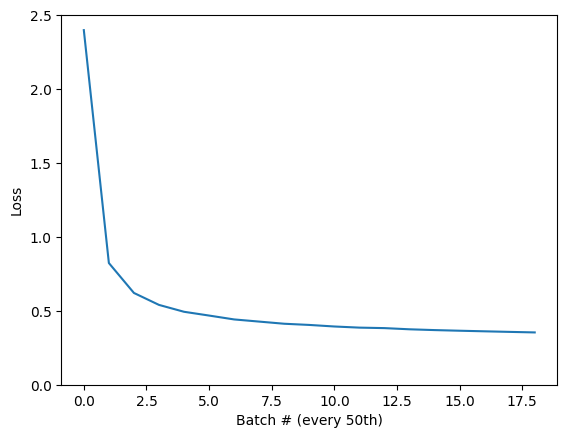

In [40]:
plt.plot(range(len(base_model_results[0])), base_model_results[0])
plt.ylim(0, 2.5)
plt.ylabel('Loss')
plt.xlabel('Batch # (every 50th)')

__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?
2. Implement momentum in the learning algorithm. How does it affect the results?
3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?
4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set.
5. If you feel adventorous, you are welcome to try to specify and experiment with other more advanced model architectures. 

**DO** Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size.

In [41]:
train_loader_64, test_loader_64 = dataload(batch_size=64)
higher_lr_model = model_trainer(
                        epochs=1,
                        lr=0.3,
                        inc_momentum=False,
                        train_loader=train_loader_64,
                        test_loader=test_loader_64,
                        weights=torch.randn(784, 10) / np.sqrt(784),
                        bias=torch.zeros(10, requires_grad=True),
                    )

Epoch: 0, B-idx: 0, Training loss: 4.069753177638756
Epoch: 0, B-idx: 50, Training loss: 0.5838543760782874
Epoch: 0, B-idx: 100, Training loss: 0.6237108671207672
Epoch: 0, B-idx: 150, Training loss: 0.9333946353702276
Epoch: 0, B-idx: 200, Training loss: 0.9486525758052431
Epoch: 0, B-idx: 250, Training loss: 0.8044456703894174
Epoch: 0, B-idx: 300, Training loss: 0.5076916917626347
Epoch: 0, B-idx: 350, Training loss: 0.7533833034145934
Epoch: 0, B-idx: 400, Training loss: 0.49189905298432945
Epoch: 0, B-idx: 450, Training loss: 0.4887732901671993
Epoch: 0, B-idx: 500, Training loss: 0.5253133965866652
Epoch: 0, B-idx: 550, Training loss: 0.48743044187837065
Epoch: 0, B-idx: 600, Training loss: 0.5854809240404286
Epoch: 0, B-idx: 650, Training loss: 0.5730641769813195
Epoch: 0, B-idx: 700, Training loss: 0.5316157257958833
Epoch: 0, B-idx: 750, Training loss: 0.6598458639435423
Epoch: 0, B-idx: 800, Training loss: 0.48043776817842204
Epoch: 0, B-idx: 850, Training loss: 0.5176904708

In [42]:
train_loader_128, test_loader_128 = dataload(batch_size=128)
higher_batch_size_model = model_trainer(
                        epochs=1,
                        lr=0.01,
                        inc_momentum=False,
                        train_loader=train_loader_128,
                        test_loader=test_loader_128,
                        weights=torch.randn(784, 10) / np.sqrt(784),
                        bias=torch.zeros(10, requires_grad=True),
                    )

Epoch: 0, B-idx: 0, Training loss: 2.566116830179178
Epoch: 0, B-idx: 50, Training loss: 0.8283506413258469
Epoch: 0, B-idx: 100, Training loss: 0.6209551277064057
Epoch: 0, B-idx: 150, Training loss: 0.539493963789584
Epoch: 0, B-idx: 200, Training loss: 0.49594786922052214
Epoch: 0, B-idx: 250, Training loss: 0.4642543588747094
Epoch: 0, B-idx: 300, Training loss: 0.4444746016058078
Epoch: 0, B-idx: 350, Training loss: 0.42886383370804126
Epoch: 0, B-idx: 400, Training loss: 0.41508100259659897
Epoch: 0, B-idx: 450, Training loss: 0.4057201443831804


In [43]:
sgd_optimizer_model = model_trainer(
                        epochs=1,
                        lr=0.01,
                        inc_momentum=False,
                        train_loader=train_loader_64,
                        test_loader=test_loader_64,
                        weights=torch.randn(784, 10) / np.sqrt(784),
                        bias=torch.zeros(10, requires_grad=True),
                        optimizer="sgd"
                    )

Epoch: 0, B-idx: 0, Training loss: 2.633403403418405
Epoch: 0, B-idx: 50, Training loss: 0.8549140611055818
Epoch: 0, B-idx: 100, Training loss: 0.6335116767489326
Epoch: 0, B-idx: 150, Training loss: 0.5511471662185848
Epoch: 0, B-idx: 200, Training loss: 0.5042737425009071
Epoch: 0, B-idx: 250, Training loss: 0.47260612945185543
Epoch: 0, B-idx: 300, Training loss: 0.45316965504686463
Epoch: 0, B-idx: 350, Training loss: 0.433381699994683
Epoch: 0, B-idx: 400, Training loss: 0.41896651610573216
Epoch: 0, B-idx: 450, Training loss: 0.4080812068763318
Epoch: 0, B-idx: 500, Training loss: 0.40040559037280743
Epoch: 0, B-idx: 550, Training loss: 0.391763336956501
Epoch: 0, B-idx: 600, Training loss: 0.3860311721687886
Epoch: 0, B-idx: 650, Training loss: 0.3774411404596717
Epoch: 0, B-idx: 700, Training loss: 0.37258428465455834
Epoch: 0, B-idx: 750, Training loss: 0.36769155428798467
Epoch: 0, B-idx: 800, Training loss: 0.36424491416289606
Epoch: 0, B-idx: 850, Training loss: 0.36028393

In [44]:
adam_optimizer_model = model_trainer(
                        epochs=1,
                        lr=0.01,
                        inc_momentum=False,
                        train_loader=train_loader_64,
                        test_loader=test_loader_64,
                        weights=torch.randn(784, 10) / np.sqrt(784),
                        bias=torch.zeros(10, requires_grad=True),
                        optimizer="adam"
                    )

Epoch: 0, B-idx: 0, Training loss: 3.355394776950259
Epoch: 0, B-idx: 50, Training loss: 0.5537656823010333
Epoch: 0, B-idx: 100, Training loss: 0.47538083079241233
Epoch: 0, B-idx: 150, Training loss: 0.4627780011817336
Epoch: 0, B-idx: 200, Training loss: 0.42861598782511406
Epoch: 0, B-idx: 250, Training loss: 0.6267641839632856
Epoch: 0, B-idx: 300, Training loss: 0.4626520844633137
Epoch: 0, B-idx: 350, Training loss: 0.4395634623121287
Epoch: 0, B-idx: 400, Training loss: 0.4625979657890573
Epoch: 0, B-idx: 450, Training loss: 0.4217089588747922
Epoch: 0, B-idx: 500, Training loss: 0.5475661917559819
Epoch: 0, B-idx: 550, Training loss: 0.41869010401170836
Epoch: 0, B-idx: 600, Training loss: 0.4628163183818875
Epoch: 0, B-idx: 650, Training loss: 0.5202935446482668
Epoch: 0, B-idx: 700, Training loss: 0.46719984467159204
Epoch: 0, B-idx: 750, Training loss: 0.46404269433765016
Epoch: 0, B-idx: 800, Training loss: 0.4963403115473958
Epoch: 0, B-idx: 850, Training loss: 0.50302225

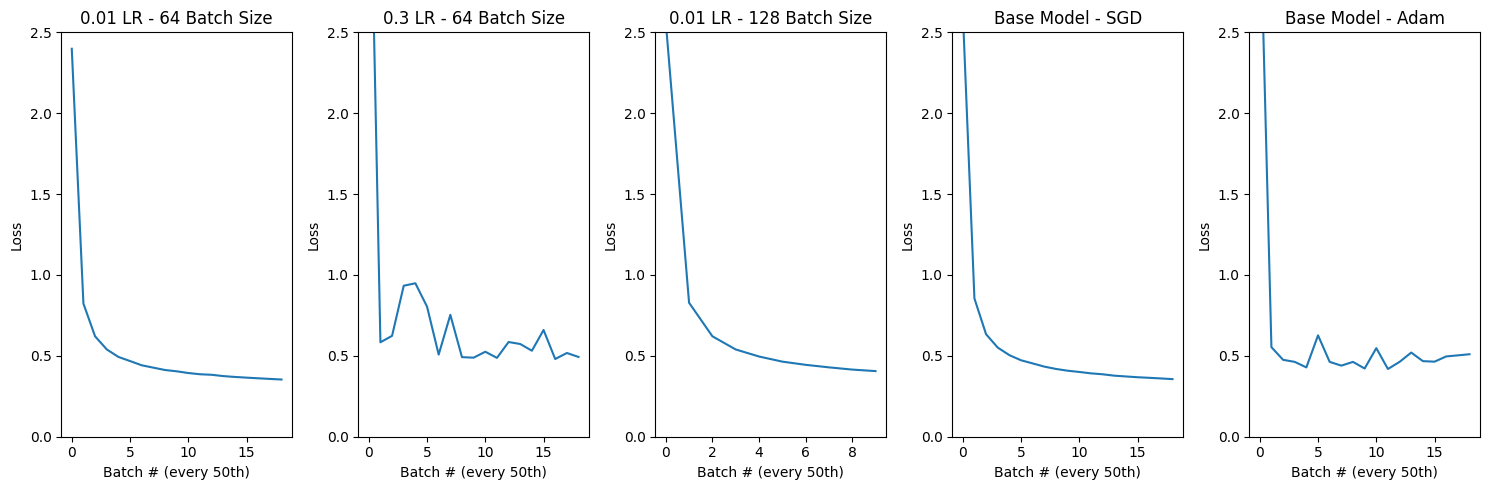

In [45]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Plot for model_1_results
axs[0].plot(range(len(base_model_results[0])), base_model_results[0])
axs[0].set_ylim(0, 2.5)
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Batch # (every 50th)')
axs[0].set_title('0.01 LR - 64 Batch Size')

# Plot for higher_lr_model
axs[1].plot(range(len(higher_lr_model[0])), higher_lr_model[0])
axs[1].set_ylim(0, 2.5)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Batch # (every 50th)')
axs[1].set_title('0.3 LR - 64 Batch Size')

# Plot for higher_batch_size_model
axs[2].plot(range(len(higher_batch_size_model[0])), higher_batch_size_model[0])
axs[2].set_ylim(0, 2.5)
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Batch # (every 50th)')
axs[2].set_title('0.01 LR - 128 Batch Size')

# Plot for higher_batch_size_model
axs[3].plot(range(len(sgd_optimizer_model[0])), sgd_optimizer_model[0])
axs[3].set_ylim(0, 2.5)
axs[3].set_ylabel('Loss')
axs[3].set_xlabel('Batch # (every 50th)')
axs[3].set_title('Base Model - SGD')

# Plot for higher_batch_size_model
axs[4].plot(range(len(adam_optimizer_model[0])), adam_optimizer_model[0])
axs[4].set_ylim(0, 2.5)
axs[4].set_ylabel('Loss')
axs[4].set_xlabel('Batch # (every 50th)')
axs[4].set_title('Base Model - Adam')

plt.tight_layout()
plt.show()

**QUESTION:** What can we then say about the effect of changing the parameters?

**ANSWER:** 
1. *Learning rate:* A high initial learning rate can result in faster convergence towards local minimum, however, it can also lead to divergent behavior, where the model fails to converge or even starts to diverge after initially converging. Clear from the plot that shows multiple fluctuations. A learning rate schedule that decreases the learning rate over time can often combine the benefits of a high learning rate initially (fast convergence) with those of a low learning rate later (fine-tuning and stability).

2. Batch size: increasing batch size dimishes uncertainty in derived gradients. While a smaller batch size is more informative, it takes more iterations to adequately converge which might not be possible under a fixed time budget. A batch size of 64 took ~3 minutes where a batch size of 128 is approximately half the time, when keeping everything else constant. Many of the advantages of using batches really shows, when using GPU's and their parralelization capabilities.

3. Optimizer: Using Gradient Descent shows consistent results and performs better on this very simple neural network. However, Adam is designed for deep neural networks and mostly performs better on complex networks. Adam computes adaptive learning rates for each parameter. It stores an exponentially decaying average of past squared gradients and an exponentially decaying average of past gradients.

**DO:** Implement momentum in the learning algorithm.

In [46]:
momentum_model = model_trainer(
                        epochs=1,
                        lr=0.01,
                        inc_momentum=True,
                        train_loader=train_loader_64,
                        test_loader=test_loader_64,
                        weights=torch.randn(784, 10) / np.sqrt(784),
                        bias=torch.zeros(10, requires_grad=True),
                    )

Epoch: 0, B-idx: 0, Training loss: 2.3406067474056154
Epoch: 0, B-idx: 50, Training loss: 0.43686940589312045
Epoch: 0, B-idx: 100, Training loss: 0.3902983312636042
Epoch: 0, B-idx: 150, Training loss: 0.36838593891561666
Epoch: 0, B-idx: 200, Training loss: 0.358645551518273
Epoch: 0, B-idx: 250, Training loss: 0.3545312211235195
Epoch: 0, B-idx: 300, Training loss: 0.3455254354043556
Epoch: 0, B-idx: 350, Training loss: 0.33038920904400504
Epoch: 0, B-idx: 400, Training loss: 0.3212367899096343
Epoch: 0, B-idx: 450, Training loss: 0.3203736045229028
Epoch: 0, B-idx: 500, Training loss: 0.32640593142302304
Epoch: 0, B-idx: 550, Training loss: 0.3128263052306704
Epoch: 0, B-idx: 600, Training loss: 0.31569586436091457
Epoch: 0, B-idx: 650, Training loss: 0.32279536861187613
Epoch: 0, B-idx: 700, Training loss: 0.3200983404636637
Epoch: 0, B-idx: 750, Training loss: 0.30775576072937644
Epoch: 0, B-idx: 800, Training loss: 0.294631714886948
Epoch: 0, B-idx: 850, Training loss: 0.3123434

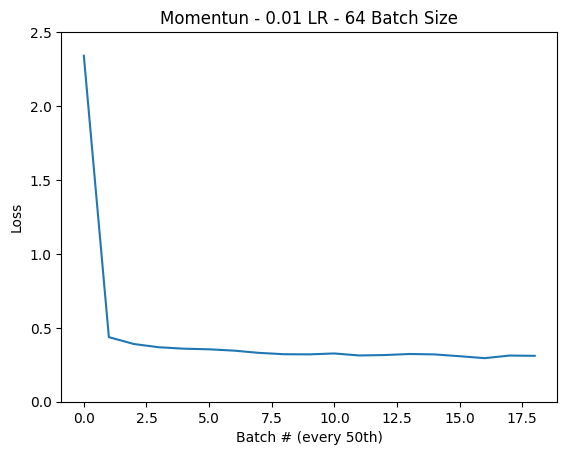

In [47]:
# Plot for higher_batch_size_model
plt.plot(range(len(momentum_model[0])), momentum_model[0])
plt.ylim(0, 2.5)
plt.ylabel('Loss')
plt.xlabel('Batch # (every 50th)')
plt.title('Momentun - 0.01 LR - 64 Batch Size')
plt.show()

![Momentum](screenshot_1.png)

**QUESTION:** How does it affect the results?

**ANSWER:** Faster convergence compared to baseline model with no momentum.

**NOTE** Applying Nesterov Accelerated Gradient defined by $\mathbf{v}_k = - \eta \nabla f(\theta_k + \alpha \mathbf{v}_{k-1}) + \alpha \mathbf{v}_{k-1}$, where $\eta$ is the the learning rate, $\theta_k$ are the parameters, $\alpha$ is the momentum coefficient, $\mathbf{v}_{k-1}$ is the velocity from the previous step, $f(x)$ is the loss function and thus, $\nabla f(x)$ is the gradient.

The intermediate step, $\theta_k + \alpha \mathbf{v}_{k-1}$, can be viewed as a “look-ahead”. It checks where the current velocity would take us and then computes the gradient. This look-ahead nature allows Nesterov Momentum to correct its course more promptly if it overshoots, leading to more effective updates.

The new parameters are then computed as $\theta_{k+1} = \theta_k + \mathbf{v}_k$

**DO:** Try with different initialization schemes for the parameters (e.g. allowing for larger values).

In [48]:
init_param_model_1 = model_trainer(
                        epochs=1,
                        lr=0.01,
                        inc_momentum=False,
                        train_loader=train_loader_64,
                        test_loader=test_loader_64,
                        weights=torch.rand(784, 10) / np.sqrt(784),
                        bias=torch.zeros(10, requires_grad=True)
                    )

Epoch: 0, B-idx: 0, Training loss: 2.2291891508773447
Epoch: 0, B-idx: 50, Training loss: 0.7734053149533424
Epoch: 0, B-idx: 100, Training loss: 0.5937598813762034
Epoch: 0, B-idx: 150, Training loss: 0.5164061804125304
Epoch: 0, B-idx: 200, Training loss: 0.47938264534671676
Epoch: 0, B-idx: 250, Training loss: 0.44896568350001437
Epoch: 0, B-idx: 300, Training loss: 0.430504740825467
Epoch: 0, B-idx: 350, Training loss: 0.4168874459035361
Epoch: 0, B-idx: 400, Training loss: 0.40302662486270036
Epoch: 0, B-idx: 450, Training loss: 0.3942432304911776
Epoch: 0, B-idx: 500, Training loss: 0.387581661581866
Epoch: 0, B-idx: 550, Training loss: 0.37769057206126416
Epoch: 0, B-idx: 600, Training loss: 0.3739976170125292
Epoch: 0, B-idx: 650, Training loss: 0.3680653319811262
Epoch: 0, B-idx: 700, Training loss: 0.3633550101918961
Epoch: 0, B-idx: 750, Training loss: 0.3581284997400953
Epoch: 0, B-idx: 800, Training loss: 0.35680371051880594
Epoch: 0, B-idx: 850, Training loss: 0.351002255

In [49]:
init_param_model_2 = model_trainer(
                        epochs=1,
                        lr=0.01,
                        inc_momentum=False,
                        train_loader=train_loader_64,
                        test_loader=test_loader_64,
                        weights=torch.randn(784, 10) / np.sqrt(784),
                        bias=torch.randn(10, requires_grad=True)
                    )

Epoch: 0, B-idx: 0, Training loss: 2.9157559467531216
Epoch: 0, B-idx: 50, Training loss: 0.8400014480675208
Epoch: 0, B-idx: 100, Training loss: 0.6291468353477369
Epoch: 0, B-idx: 150, Training loss: 0.5431981841638398
Epoch: 0, B-idx: 200, Training loss: 0.49568787579343265
Epoch: 0, B-idx: 250, Training loss: 0.4650537829631681
Epoch: 0, B-idx: 300, Training loss: 0.44372752720295494
Epoch: 0, B-idx: 350, Training loss: 0.4279078377653032
Epoch: 0, B-idx: 400, Training loss: 0.4174247190896382
Epoch: 0, B-idx: 450, Training loss: 0.4057494394306435
Epoch: 0, B-idx: 500, Training loss: 0.3955898656329112
Epoch: 0, B-idx: 550, Training loss: 0.3873785991372584
Epoch: 0, B-idx: 600, Training loss: 0.38064059982104087
Epoch: 0, B-idx: 650, Training loss: 0.3762034220037176
Epoch: 0, B-idx: 700, Training loss: 0.37159113068062105
Epoch: 0, B-idx: 750, Training loss: 0.3672755761727341
Epoch: 0, B-idx: 800, Training loss: 0.36252273703371285
Epoch: 0, B-idx: 850, Training loss: 0.3596669

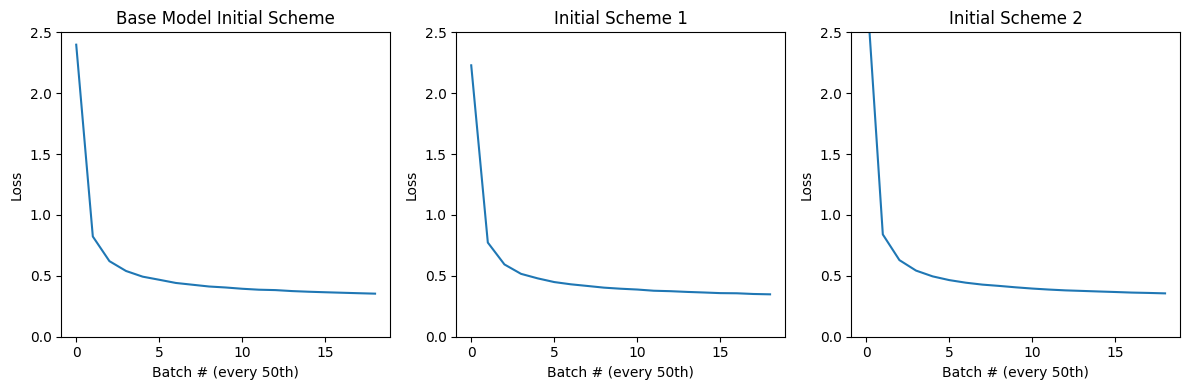

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(range(len(base_model_results[0])), base_model_results[0])
axs[0].set_ylim(0, 2.5)
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Batch # (every 50th)')
axs[0].set_title('Base Model Initial Scheme')

axs[1].plot(range(len(init_param_model_1[0])), init_param_model_1[0])
axs[1].set_ylim(0, 2.5)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Batch # (every 50th)')
axs[1].set_title('Initial Scheme 1')

axs[2].plot(range(len(init_param_model_2[0])), init_param_model_2[0])
axs[2].set_ylim(0, 2.5)
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Batch # (every 50th)')
axs[2].set_title('Initial Scheme 2')

plt.tight_layout()
plt.show()

**QUESTION:** How does it affect the behavior of the algorithm?

**ANSWER:** The code fails if the init parameters are too high, thus, we see no significant changes in the two schemes compared to the baseline model. Improper initialization can exacerbate the vanishing or exploding gradients problem, especially in deep networks. If weights are too small, the signal shrinks as it passes through each layer and disappears (vanishes) by the time it reaches the last layer. If the weights are too large, the signal grows exponentially and can become too large (explode) for the network to learn anything.

**NOTE** If all weights are initialized to the same value, such as zero, the neurons in each layer will learn the same features during training, which is not desirable. Random initialization of weights is crucial to break symmetry and ensure neurons learn different things.

**DO:** Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set.

In [51]:
_, train_acc, test_acc = model_trainer(
                        epochs=1,
                        lr=0.01,
                        inc_momentum=True,
                        train_loader=train_loader_64,
                        test_loader=test_loader_64,
                        weights=torch.randn(784, 10) / np.sqrt(784),
                        bias=torch.randn(10, requires_grad=True),
                        optimizer="sgd"
                    )

print("Train accuracy: {}\n".format(train_acc), "Test accuracy: {}".format(test_acc))

Epoch: 0, B-idx: 0, Training loss: 0.3041465542614778
Epoch: 0, B-idx: 50, Training loss: 0.2893904212897997
Epoch: 0, B-idx: 100, Training loss: 0.29760369751800986
Epoch: 0, B-idx: 150, Training loss: 0.29313686617942
Epoch: 0, B-idx: 200, Training loss: 0.28469482319219025
Epoch: 0, B-idx: 250, Training loss: 0.2879297058306523
Epoch: 0, B-idx: 300, Training loss: 0.2924211299749834
Epoch: 0, B-idx: 350, Training loss: 0.28366089668641215
Epoch: 0, B-idx: 400, Training loss: 0.2832114392542032
Epoch: 0, B-idx: 450, Training loss: 0.2803034077483867
Epoch: 0, B-idx: 500, Training loss: 0.28479391605710425
Epoch: 0, B-idx: 550, Training loss: 0.2757383828867537
Epoch: 0, B-idx: 600, Training loss: 0.27496729737548814
Epoch: 0, B-idx: 650, Training loss: 0.2830388263415998
Epoch: 0, B-idx: 700, Training loss: 0.2764037908640688
Epoch: 0, B-idx: 750, Training loss: 0.2778018152337275
Epoch: 0, B-idx: 800, Training loss: 0.2892812730224211
Epoch: 0, B-idx: 850, Training loss: 0.269940428